Just a notebook that creates a simple velocity model using numpy arrays and again with the SegyIO library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

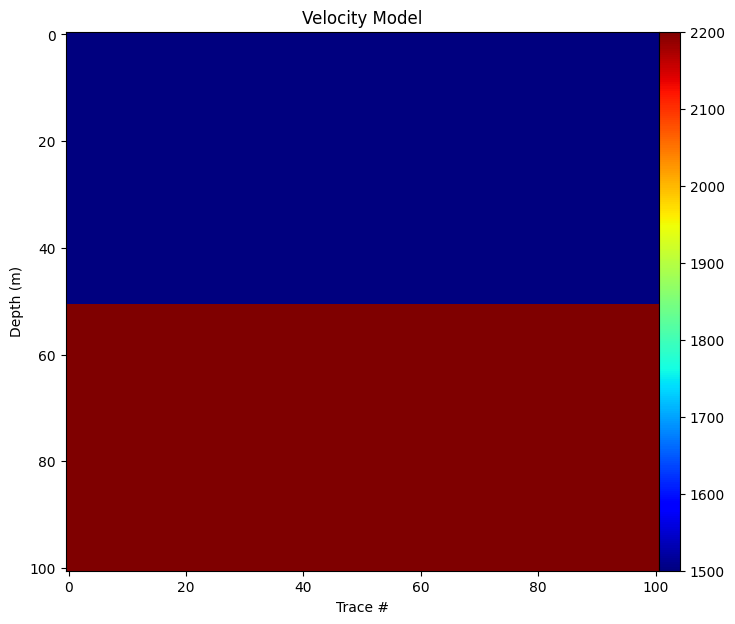

In [7]:
# Define a velocity model - velocity is in m/s - 100x100 cells
vp = np.empty((101, 101), dtype=np.float32)  #cells start at 1 not zero
vp[:51,:] = 1500.
vp[51:,:] = 2200.

# save the transposed version to ascii format
np.savetxt('velsfile.asc',np.transpose(vp),fmt='%1.7f') 

#plot velocity model
fig, axes = plt.subplots(1, 1, figsize=(9,7))
ax = axes 
ax.set_title("Velocity Model")
plot = ax.imshow(vp, cmap="jet", aspect='auto', origin='upper')
fig.colorbar(plot, ax=ax, pad=0, aspect=25)
ax.set_xlabel('Trace #')
ax.set_ylabel('Depth (m)')
plt.show()


In [3]:
# save a .segy file using segyio
# https://github.com/equinor/segyio/blob/master/python/examples/make-file.py
spec = segyio.spec()
filename = 'velsfile.segy'

# To create a file from nothing, we need to tell segyio about the structure of
# the file, i.e. its inline numbers, crossline numbers, etc. 
# Header information, sorting, and formatting is listed here:
# https://segyio.readthedocs.io/en/latest/segyio.html#segyio.TraceField
spec.sorting = segyio.TraceSortingFormat.INLINE_SORTING # or use 2==inline sorting
spec.format  = segyio.SegySampleFormat.IBM_FLOAT_4_BYTE # or use 1==IBM_FLOAT_4_BYTE
spec.samples = range(0,101)
spec.ilines = [1]
spec.xlines = range(1,101+1)
step = 100 #dz

with segyio.create(filename, spec) as f:
    # Write the file trace-by-trace and update headers with iline/xline numbers
    tr = 0
    for il in spec.ilines:
        for xl in spec.xlines:
            f.header[tr] = {
                segyio.TraceField.TRACE_SEQUENCE_LINE : tr+1,
                segyio.TraceField.FieldRecord  : il,        # or use segyio.su.fldr
                segyio.TraceField.CDP  : xl,                # or use segyio.su.cdp
                segyio.TraceField.INLINE_3D  : il,
                segyio.TraceField.CROSSLINE_3D  : xl,
                segyio.TraceField.TRACE_SAMPLE_INTERVAL  : int(step),
                segyio.TraceField.TRACE_SAMPLE_COUNT : len(spec.samples)
                }
            f.trace[tr] = np.transpose(vp)[tr]
            tr += 1

c:\Users\Mitch\AppData\Local\Programs\Python\Python311\Lib\site-packages\segyio\utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)


In [4]:
# reload .segy file using segyio - to check exported segy file all good
# https://github.com/equinor/segyio-notebooks/blob/master/notebooks/basic/02_segy_quicklook.ipynb

with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)

print(f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms')

N Traces: 101, N Samples: 101, Sample rate: 4.0ms


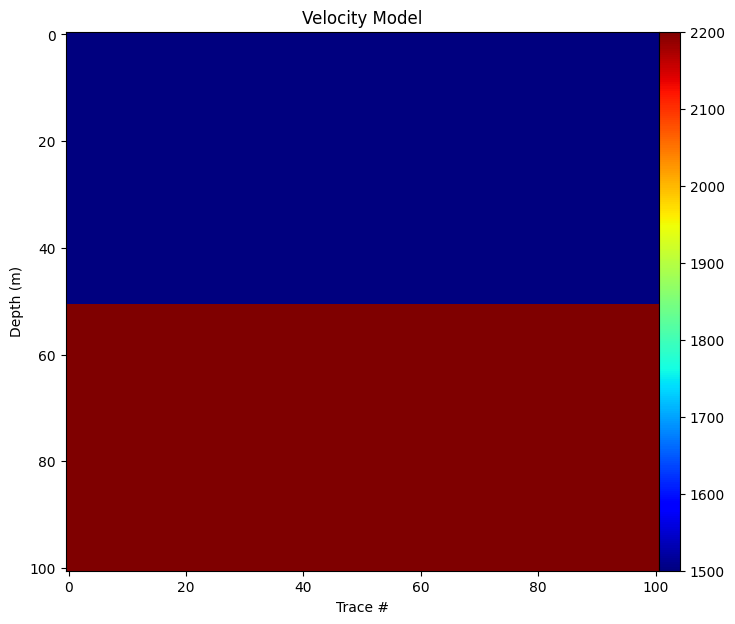

In [6]:
#plot velocity model
fig, axes = plt.subplots(1, 1, figsize=(9, 7))
ax = axes 
ax.set_title("Velocity Model")
plot = ax.imshow(data.T, cmap="jet", aspect='auto', origin='upper')
fig.colorbar(plot, ax=ax, pad=0, aspect=25)
ax.set_xlabel('Trace #')
ax.set_ylabel('Depth (m)')
plt.show()